In [51]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates


import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.gnn import create_features, create_label
from spektral.layers import GCNConv
from spektral.utils import gcn_filter

In [52]:
file_path = "../data/parsed_dataset.csv"
date_column = "period"
target_column = "value"
id_column = "parent"
df = pd.read_csv(file_path)[[date_column, target_column, id_column]]
df[date_column] = pd.to_datetime(df[date_column])
df = df.groupby([date_column, id_column])[target_column].sum().reset_index()
unique_dates = df[date_column].unique()
um_countries_regions = len(df[id_column].unique())
df.head()

,period,parent,value
0,2023-01-02 06:00:00,CISO,24640
1,2023-01-02 06:00:00,ERCO,37574
2,2023-01-02 06:00:00,ISNE,10377
3,2023-01-02 06:00:00,MISO,59560
4,2023-01-02 06:00:00,NYIS,14054


In [53]:
unique_dates

<DatetimeArray>
['2023-01-02 06:00:00', '2023-01-02 07:00:00', '2023-01-02 08:00:00',
 '2023-01-02 09:00:00', '2023-01-02 10:00:00', '2023-01-02 11:00:00',
 '2023-01-02 12:00:00', '2023-01-02 13:00:00', '2023-01-02 14:00:00',
 '2023-01-02 15:00:00',
 ...
 '2024-04-23 15:00:00', '2024-04-23 16:00:00', '2024-04-23 17:00:00',
 '2024-04-23 18:00:00', '2024-04-23 19:00:00', '2024-04-23 20:00:00',
 '2024-04-23 21:00:00', '2024-04-23 22:00:00', '2024-04-23 23:00:00',
 '2024-04-24 00:00:00']
Length: 11467, dtype: datetime64[ns]

In [54]:
# pivot_df = df.pivot_table(index=date_column, columns=id_column, values=target_column)

df.rename(columns={"index": date_column}, inplace=True)
df.head()


,period,parent,value
0,2023-01-02 06:00:00,CISO,24640
1,2023-01-02 06:00:00,ERCO,37574
2,2023-01-02 06:00:00,ISNE,10377
3,2023-01-02 06:00:00,MISO,59560
4,2023-01-02 06:00:00,NYIS,14054


In [55]:
unstaked_df = df.copy()
unstaked_df["id"] = unstaked_df[id_column]
unstaked_df.set_index(["id", date_column], inplace=True)

# Dropping columns not needed for the analysis
unstaked_df.drop([id_column], axis=1, inplace=True)

# Converting data to float and unstacking
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

# Displaying the shape and head of the updated DataFrame
print(unstaked_df.shape)
unstaked_df.iloc[:, :15].head()

(8, 11467)


period,2023-01-02 06:00:00,2023-01-02 07:00:00,2023-01-02 08:00:00,2023-01-02 09:00:00,2023-01-02 10:00:00,2023-01-02 11:00:00,2023-01-02 12:00:00,2023-01-02 13:00:00,2023-01-02 14:00:00,2023-01-02 15:00:00,2023-01-02 16:00:00,2023-01-02 17:00:00,2023-01-02 18:00:00,2023-01-02 19:00:00,2023-01-02 20:00:00
id,,,,,,,,,,,,,,,
CISO,24640.0,24260.0,23212.0,21897.0,21483.0,20776.0,20331.0,20336.0,20528.0,21469.0,22712.0,23099.0,22973.0,23347.0,23475.0
ERCO,37574.0,36065.0,35064.0,34364.0,34020.0,34206.0,34933.0,36132.0,37235.0,38147.0,39966.0,41262.0,42574.0,43367.0,43897.0
ISNE,10377.0,10102.0,9993.0,10029.0,10265.0,10764.0,11484.0,12077.0,12590.0,12989.0,13187.0,13239.0,13182.0,13203.0,13214.0
MISO,59560.0,57790.0,56675.0,56203.0,56188.0,57120.0,58856.0,61298.0,63229.0,64857.0,66974.0,68236.0,69050.0,69308.0,69315.0
NYIS,14054.0,13638.0,13371.0,13300.0,13400.0,13763.0,14384.0,15025.0,15617.0,16036.0,16198.0,16130.0,16146.0,16069.0,16226.0


In [56]:
sequence_length = 24

In [57]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = unique_dates[0]
valid_date = unique_dates[int(len(unique_dates) *0.8)+1]
test_date = unique_dates[int(len(unique_dates) *0.9)]

In [58]:
unstaked_df.columns

DatetimeIndex(['2023-01-02 06:00:00', '2023-01-02 07:00:00',
               '2023-01-02 08:00:00', '2023-01-02 09:00:00',
               '2023-01-02 10:00:00', '2023-01-02 11:00:00',
               '2023-01-02 12:00:00', '2023-01-02 13:00:00',
               '2023-01-02 14:00:00', '2023-01-02 15:00:00',
               ...
               '2024-04-23 15:00:00', '2024-04-23 16:00:00',
               '2024-04-23 17:00:00', '2024-04-23 18:00:00',
               '2024-04-23 19:00:00', '2024-04-23 20:00:00',
               '2024-04-23 21:00:00', '2024-04-23 22:00:00',
               '2024-04-23 23:00:00', '2024-04-24 00:00:00'],
              dtype='datetime64[ns]', name='period', length=11467, freq=None)

In [73]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date + timedelta(hours=sequence_length), valid_date, freq="H")):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions, "H")
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_train_seq = np.concatenate(X_seq, axis=0).astype("float32")
X_train_cor = np.concatenate(X_cor, axis=0).astype("float32")
X_train_feat = np.concatenate(X_feat, axis=0).astype("float32")
y_train = np.concatenate(y, axis=0).astype("float32")

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

100%|██████████| 9151/9151 [00:44<00:00, 205.61it/s]

(9151, 24, 8) (9151, 8, 8) (9151, 8, 7) (9151, 8)


In [60]:
y_train

array([[ 26873.,  39075.,  10921., ...,  73416.,   1848.,  26810.],
       [ 27590.,  37418.,  10870., ...,  73749.,   1905.,  29601.],
       [ 26518.,  39815.,  10678., ...,  75681.,   1792.,  30635.],
       ...,
       [ 26563.,  69390.,  13257., ..., 115349.,   1835.,  40985.],
       [ 25925.,  56812.,  13927., ..., 111006.,   1785.,  35446.],
       [ 25824.,  46405.,  13332., ..., 100700.,   1751.,  36727.]],
      dtype=float32)

In [74]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date + timedelta(hours=sequence_length), test_date, freq="H")):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions, "H")
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_valid_seq = np.concatenate(X_seq, axis=0).astype("float32")
X_valid_cor = np.concatenate(X_cor, axis=0).astype("float32")
X_valid_feat = np.concatenate(X_feat, axis=0).astype("float32")
y_valid = np.concatenate(y, axis=0).astype("float32")

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

100%|██████████| 1123/1123 [00:05<00:00, 202.54it/s]


(1123, 24, 8) (1123, 8, 8) (1123, 8, 7) (1123, 8)


In [75]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(
    pd.date_range(test_date + timedelta(hours=sequence_length), unique_dates[-1], freq="H")
):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions, "H")
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_test_seq = np.concatenate(X_seq, axis=0).astype("float32")
X_test_cor = np.concatenate(X_cor, axis=0).astype("float32")
X_test_feat = np.concatenate(X_feat, axis=0).astype("float32")
y_test = np.concatenate(y, axis=0).astype("float32")

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|██████████| 1123/1123 [00:05<00:00, 197.15it/s]

(1123, 24, 8) (1123, 8, 8) (1123, 8, 7) (1123, 8)


In [76]:
X_train_lap = gcn_filter(1 - np.abs(X_train_cor))
X_valid_lap = gcn_filter(1 - np.abs(X_valid_cor))
X_test_lap = gcn_filter(1 - np.abs(X_test_cor))

In [77]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###
pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)
models = []
model_files = []
from keras.callbacks import Callback

class DebuggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict([X_valid_seq, X_valid_lap, X_valid_feat])
        print(f"Epoch {epoch}: sample predictions {pred[:5]}")
for region in range(um_countries_regions):
    print("-------", "region", region, "-------")

    es = EarlyStopping(
        patience=5,
        verbose=1,
        min_delta=0.1,  # More sensitive change detection
        monitor="val_loss",
        mode="auto",
        restore_best_weights=True
    )

    inp_seq = Input((sequence_length, um_countries_regions))
    inp_lap = Input((um_countries_regions, um_countries_regions))
    inp_feat = Input((um_countries_regions, X_train_feat.shape[-1]))

    x = GCNConv(128, activation="relu")([inp_feat, inp_lap])
    x = GCNConv(64, activation="relu")([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation="relu", return_sequences=True)(inp_seq)
    xx = LSTM(64, activation="relu")(xx)

    x = Concatenate()([x, xx])
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Reduced learning rate
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    model.fit(
        [X_train_seq, X_train_lap, X_train_feat],
        y_train[:, region],
        epochs=1000,
        batch_size=16,
        validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:, region]),
        callbacks=[es, DebuggingCallback()],
        verbose=1
    )
    model.save(f"../stored_models/gnn/gnn_{region}.h5")
    model_files.append(f"gnn_{region}")
    models.append(model)


------- region 0 -------
Epoch 1/1000
36/36 [==============================] - 1s 9ms/step loss: 98343544.0000 - root_mean_squared_error
Epoch 0: sample predictions [[26707.52 ]
 [26813.137]
 [26888.043]
 [26948.492]
 [26969.266]]
572/572 [==============================] - 15s 21ms/step - loss: 98125704.0000 - root_mean_squared_error: 9905.8418 - val_loss: 9318057.0000 - val_root_mean_squared_error: 3052.5493
Epoch 2/1000
36/36 [==============================] - 0s 10ms/steploss: 40098976.0000 - root_mean_squared_er
Epoch 1: sample predictions [[24937.418]
 [25004.129]
 [25048.818]
 [25047.24 ]
 [25040.91 ]]
572/572 [==============================] - 12s 21ms/step - loss: 40098976.0000 - root_mean_squared_error: 6332.3750 - val_loss: 10995592.0000 - val_root_mean_squared_error: 3315.9602
Epoch 3/1000
36/36 [==============================] - 0s 9ms/step loss: 35968848.0000 - root_mean_squared_erro
Epoch 2: sample predictions [[27802.035]
 [27886.691]
 [27970.094]
 [27987.955]
 [27992.12

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/1000
36/36 [==============================] - 1s 10ms/steploss: 259645792.0000 - root_mean_squared_erro
Epoch 0: sample predictions [[61199.26 ]
 [61528.695]
 [61807.035]
 [61898.523]
 [62109.414]]
572/572 [==============================] - 17s 24ms/step - loss: 259503216.0000 - root_mean_squared_error: 16109.1035 - val_loss: 79712608.0000 - val_root_mean_squared_error: 8928.1914
Epoch 2/1000
36/36 [==============================] - 0s 11ms/steploss: 137735856.0000 - root_mean_squared_err
Epoch 1: sample predictions [[52286.47 ]
 [52502.234]
 [52874.293]
 [53020.758]
 [53194.3  ]]
572/572 [==============================] - 13s 22ms/step - loss: 137735856.0000 - root_mean_squared_error: 11736.0918 - val_loss: 40178264.0000 - val_root_mean_squared_error: 6338.6328
Epoch 3/1000
36/36 [==============================] - 0s 10ms/steploss: 136890656.0000 - root_mean_squared_err
Epoch 2: sample predictions [[51028.83]
 [51260.79]
 [51656.22]
 [51345.57]
 [51485.07]]
572/572 [==========

In [78]:
for region, model in enumerate(models):

    pred_valid_all[:, region] = model.predict(
        [X_valid_seq, X_valid_lap, X_valid_feat]
    ).ravel()
    pred_test_all[:, region] = model.predict(
        [X_test_seq, X_test_lap, X_test_feat]
    ).ravel()



reverse_valid = y_valid
reverse_test = y_test

36/36 [==============================] - 0s 11ms/step


In [79]:
def plot_predictions(y_true, y_pred, store, item):
    y_true = y_true.reshape(1, -1, um_countries_regions)
    y_pred = y_pred.reshape(1, -1, um_countries_regions)
    t = y_true[item, :, store]
    for i in range(um_countries_regions):

        plt.plot(y_true[item, :, store], label="true")
        plt.plot(y_pred[item, :, store], label="prediction")
        plt.title(f"store: {store} item: {item}")
        plt.legend()
        plt.ylabel("sales")
        plt.xlabel("date")

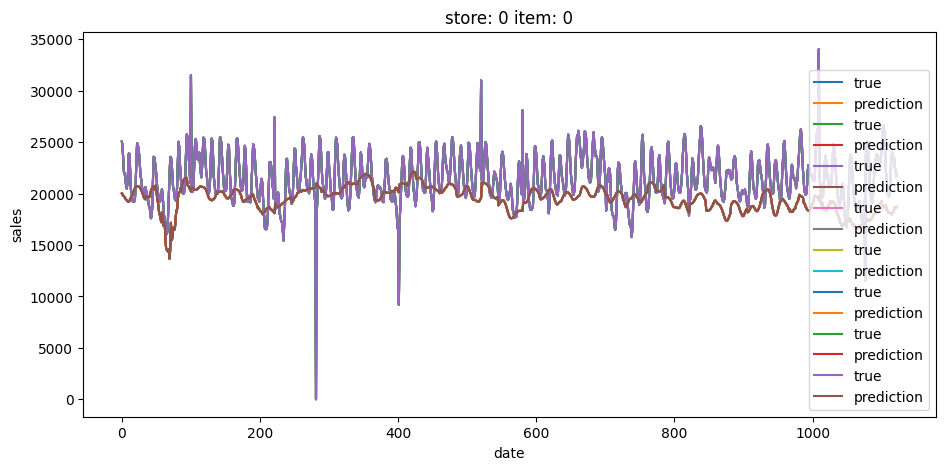

In [80]:
plt.figure(figsize=(11, 5))
plot_predictions(reverse_test, pred_test_all, 0, 0)

In [81]:
y_test

array([[2.5053e+04, 4.2365e+04, 1.1081e+04, ..., 7.6869e+04, 1.6550e+03,
        2.7732e+04],
       [2.4445e+04, 4.0465e+04, 1.0797e+04, ..., 7.5167e+04, 1.6060e+03,
        2.7119e+04],
       [2.3246e+04, 3.9603e+04, 1.0717e+04, ..., 7.4552e+04, 1.5540e+03,
        2.6734e+04],
       ...,
       [2.2409e+04, 4.9379e+04, 1.0000e+00, ..., 8.1665e+04, 1.5610e+03,
        3.1138e+04],
       [2.1623e+04, 4.9889e+04, 1.0000e+00, ..., 8.3029e+04, 1.6560e+03,
        3.1182e+04],
       [2.1946e+04, 4.9880e+04, 1.0000e+00, ..., 8.4211e+04, 1.7190e+03,
        3.1108e+04]], dtype=float32)

In [82]:
y_true = np.sum(reverse_test, axis=1)
pred = np.sum(pred_test_all, axis=1)


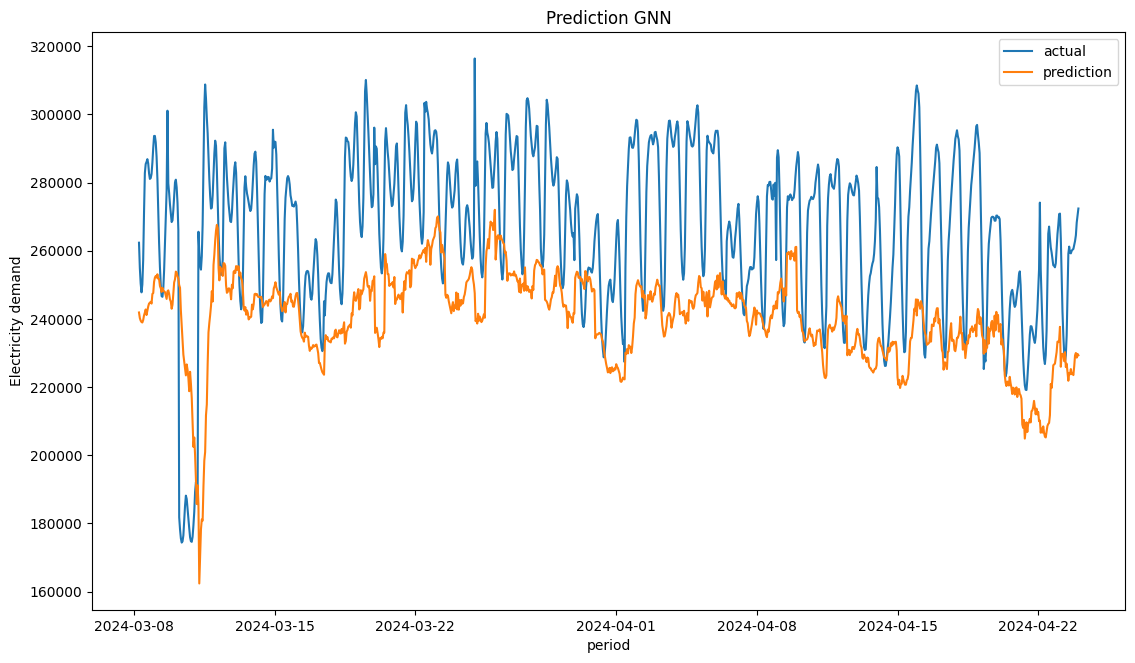

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(unique_dates[-len(pred):], np.sum(y_test, axis=1)-1, label="actual")
ax.plot(unique_dates[-len(pred):], pred-1, label="prediction")
ax.set_title("Prediction GNN")
ax.set_ylabel("Electricity demand")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [84]:
print_evaluation_metrics(pred-1, y_true-1, np.sum(y_train, axis=1)-1)

Evaluation Metrics:
MSE: 1122847272.82
RMSE: 33508.91
MAE: 28678.56
MAPE: 10.53
SMAPE: 11.21
MASE: 3.81
